In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
import os
import detection as dt

Set-Up

In [9]:
ticker = 'HLF'
auto_threshold = True
threshold = 2.1
pattern_lengths=[10, 15, 20, 25, 30, 35, 40, 45, 50]
window_size=50
overlap=10
percentile=10
data_dir = '../trades/data/output'
output_dir = 'detection/data/output'

Loading data...

In [10]:
data_dict = dt.load_ticker_data(ticker, 'baseline', data_dir)
print(f"   Loaded {len(data_dict['actual'])} days of data\n")
patterns = dt.generate_insider_patterns(pattern_lengths)
print(f"   Created {len(patterns)} patterns\n")


data_dict_enhanced = dt.load_ticker_data(ticker, 'enhanced', data_dir)
patterns_enhanced = dt.generate_insider_patterns(pattern_lengths)


   Loaded 230 days of data

   Created 9 patterns



Determining threshold...


DTW Distance Distribution:
  min     :  2.832
  p10     :  7.468
  p25     : 11.075
  median  : 16.102
  p75     : 24.275
  max     : 54.852

Suggested threshold (10th %ile): 7.468


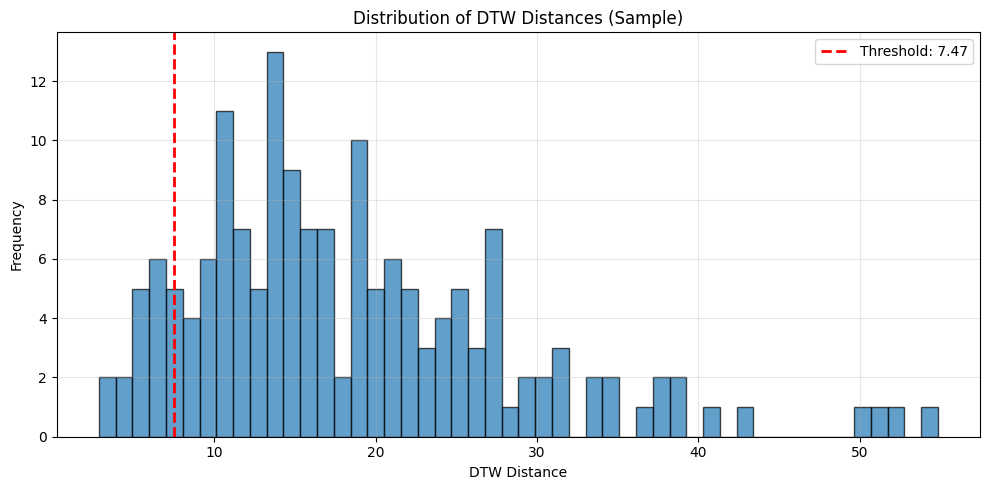


DTW Distance Distribution:
  min     :  2.661
  p10     :  7.147
  p25     : 10.542
  median  : 16.115
  p75     : 24.792
  max     : 61.687

Suggested threshold (10th %ile): 7.147


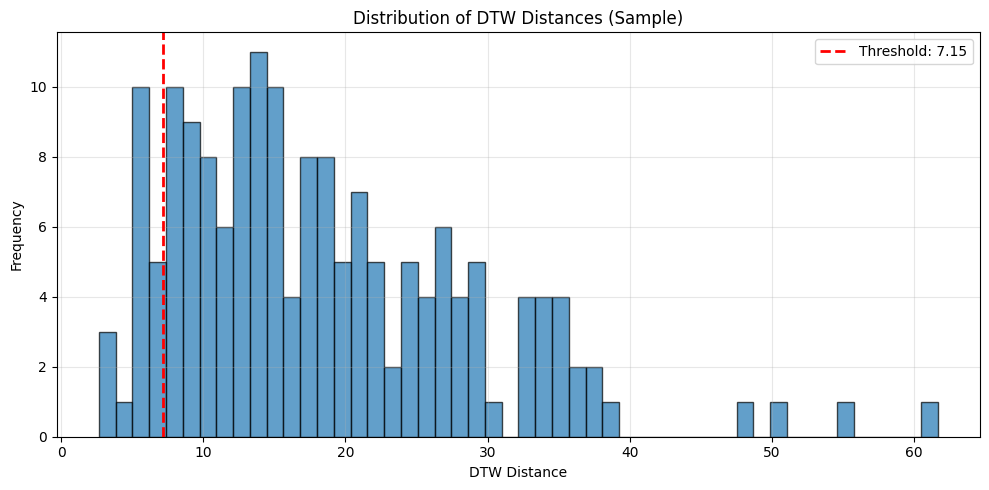

In [11]:
if auto_threshold:
        distances = dt.sample_dtw_distances(data_dict['point'], patterns, 
                                        window_size, overlap, sample_rate=0.2)
        threshold = dt.suggest_threshold(distances, percentile)
        dt.plot_distance_distribution(distances, threshold)

        distances_enhanced = dt.sample_dtw_distances(data_dict_enhanced['point'], patterns_enhanced, 
                                        window_size, overlap, sample_rate=0.2)
        threshold_enhanced = dt.suggest_threshold(distances_enhanced, percentile)
        dt.plot_distance_distribution(distances_enhanced, threshold_enhanced)
else:
    print(f"3. Using manual threshold: {threshold}\n")

Detection   

In [12]:
results = dt.run_detection(data_dict, patterns, threshold, window_size, overlap)
results_enhanced = dt.run_detection(data_dict_enhanced, patterns_enhanced, threshold_enhanced, window_size, overlap)

Point-by-Point      :   86 anomalies
Sequence            :    0 anomalies
Window              :    0 anomalies
Point-by-Point      :   81 anomalies
Sequence            :  581 anomalies
Window              :  581 anomalies


Summary

In [13]:
total = sum(len(v) for v in results.values())
totals_enhanced = sum(len(v) for v in results_enhanced.values())
summary = dt.summarize_results(results)
summary_enhanced = dt.summarize_results(results_enhanced)
if not summary.empty:
    print(summary.to_string(index=False))
    print(summary_enhanced.to_string(index=False))

print("\n\nPattern Breakdown:")
breakdown = dt.pattern_breakdown(results)
breakdown_enhanced = dt.pattern_breakdown(results_enhanced)
if not breakdown.empty:
    print(breakdown.to_string())
    print(breakdown_enhanced.to_string())
else:
    print("No anomalies detected")

        Method  Count  DTW Min  DTW Mean  DTW Max  Patterns
Point-by-Point     86 2.832261  5.577286 7.446984         2
        Method  Count  DTW Min  DTW Mean  DTW Max  Patterns
Point-by-Point     81 2.660582  5.497269 7.090515         2
      Sequence    581 3.082985  4.794748 6.992020         4
        Window    581 3.082985  4.794748 6.992020         4


Pattern Breakdown:
            total   avg_dtw  Point-by-Point
pattern_id                                 
1              71  5.402860              71
2              15  6.402901              15
            total   avg_dtw  Point-by-Point  Sequence  Window
pattern_id                                                   
1             434  3.814557              66       184     184
2             333  4.562231              15       159     159
3             268  5.498228               0       134     134
4             208  6.579374               0       104     104
